In [19]:
"""
    Variables from DataFormatting.ipynb
"""
%store -r df
%store -r KEYWORDS
%store -r noisy_punct
%store -r ks
%store -r map_
%store -r indices_of_first_attempts_per_user
%store -r recipes_indices
%store -r users_to_groups

In [20]:
import numpy as np
import pandas as pd
import ast 
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})
sns.set_style('darkgrid')

## Matching the users to their groups
If we follow the logic of the paper on Relex, we have the following structure for the groups:

| Group 1 | Group 2|
| :----: | :---:|
|Adaptive Feedback | No Adaptive Feedback| 

In [22]:
dframe = df.copy()
all_keystrokes = list(map(lambda _ : ast.literal_eval(_) , df['ks'].values))
sorted_users = sorted(set(df['user_id'].values))

In [23]:
matching_data = pd.read_csv('data/groupmatching.csv')
s = matching_data.sort_values(by=['group', 'user_id'], ascending=True)

"""
    Basically what we do here is simple. We have the data matching each user to which group they belong to.
    So what we do is we create an array INDICES. We create a dictionnary which maps each group to the users in it.
    Then iterate over the users of each group and find their index in the sorted users array. 

    so INDICES has 5 arrays, each containing the indices of the users in that group.
    
"""
groups = {1: [], 2: []}
for i, dic in enumerate(s.values):
    user = dic[1]
    if user in sorted_users:
        group = users_to_groups[user]
        if group == 2:
            groups[1].append(user)
        elif group == 4:
            groups[2].append(user)


INDICES = []
for group in [1,2]:
    indices = []
    for user in groups[group]:
        i = np.where(np.array(sorted_users) == user)
        indices.append(i[0][0])
    INDICES.append(indices)

## Comparing text insertions with deletions

First what we want to do is count the number of insertions and deletions for each student. 

**We consider an insertion as being any character that was typed without being in  `KEYWORDS`. (whitespaces included)**

**We consider deletions as being any character being equal to 'Backspace' or 'Delete'.**

we will create a tuple for each student of the form ```(total insertions, total deletions)```.
We create the same thing for each set of keystrokes in the dataset but it will be useful for later.

Also, what we do for each user: map their typing to insertions and deletions as **0s for insertions, 1s for deletions** and try to see what different sequences of inserts/delete all users have.

In [24]:
recipe_insertions_deletions = []
user_insertions_deletions = []
for user in sorted_users:
    indices_where_written = dframe[dframe['user_id'] == user].index
    insertions = 0
    deletions = 0
    for index in indices_where_written:
        ks_set = all_keystrokes[index]
        recipe_sequence = []
        recipe_insertion = 0
        recipe_deletion = 0
        for entry in ks_set:
            word = entry['word']
            if word not in KEYWORDS:
                #+1 to account for the space
                num_insertions = len(word) + 1
                insertions += num_insertions 
                recipe_insertion += num_insertions
            elif word == 'Backspace' or word == 'Delete':
                deletions += 1
                recipe_deletion += 1
        recipe_insertions_deletions.append((recipe_insertion, recipe_deletion))                  
    user_insertions_deletions.append((insertions, deletions))

Now for any user, we map their insertions and deletions to the % of each and have pandas plot the % at each revision step. 
We also have a function that plots the total number of insertions and deletions.

Revision steps occur at each set of keystrokes when the `user_id` is the same. However, it is important to note some revision steps are not a revision steps but rather the start of another recipe. This is clearly visible in the plots when the number of insertions at step n is much smaller than the number of insertions at step n+1

We created a plot that takes any user index and returns the amount of revision they had with the % of deletions and insertions at each step

Here are useful functions.


In [25]:
def compute_user_range(user_index):
    """ 
    Computes the total range of indices over which a user wrote in the dataset
    For example, if user 0 wrote in the dataset from index 0 to index 3, then this returns the tuples of insertions and deletions
    for each index in [0, 1, 2, 3] so it will be a list of 4 tuples

    Args:
        user_index (int): user in the dataframe

    Returns:
        list(tuple): list of tuples of insertions and deletions for each index in the range
    """
    user_range = None
    if user_index == len(sorted_users) - 1:
        user_range = recipe_insertions_deletions[indices_of_first_attempts_per_user[user_index]:]
    else:
        user_range = recipe_insertions_deletions[indices_of_first_attempts_per_user[user_index]:indices_of_first_attempts_per_user[user_index+1]]
    return user_range

def plot_percentages_for_user(user_index):
    """
    Plots the percentages of insertions and deletions at each revision step t
    A bit of hardcoded constants but the data won't change overnight so ...
    Args:
        user_index (int): index of user to plot
    """
    assert user_index >= 0 and user_index < len(sorted_users)
    user_range = compute_user_range(user_index)
    percentage = []
    for i, (insert,deletes) in enumerate(user_range):
        s = insert + deletes
        percentage.append((round(insert/s*100, 2), round(deletes/s*100, 2)))

    dfr = pd.DataFrame(percentage, columns=['insertion %', 'deletion %'])
    dfr.plot(kind='bar', xlabel='revision step for user ' + str(user_index) + ' : ' + sorted_users[user_index], ylabel='percentage', figsize=(5,3))
    
def plot_stats_for_user(user_index):
    """
    Same idea as percentages but this method plots the absolute numbers 
    of insertions and deletions

    Args:
        user_index (int): index of user to plot
    """
    assert user_index >= 0 and user_index < len(sorted_users)
    user_range= compute_user_range(user_index)
    dfr = pd.DataFrame(user_range, columns=['insertions', 'deletions'])
    dfr.plot(kind='bar', xlabel='revision step for user ' + str(user_index) + ' : ' + sorted_users[user_index], figsize=(5,3))
    print(sorted_users[user_index])

def collect_data_from_user(user_index):
    """
    Collects all the content a user writes on the plaform.

    Args:
        user_index (int): user index to collect data from

    Returns:
        pd.DataFrame: a sublist of tuples from the given users revisions
    """
    assert user_index >= 0 and user_index < len(sorted_users)
    return pd.DataFrame(compute_user_range(user_index), columns=['insertions', 'deletions'])

### Finding patterns in student insert/delete sequences

We create a function that will apply `PrefixSpan` on the nth revision step for each user.
That means, for revision step 0, the method will apply PS on the first things student write, without having had any suggestions from the model.
if $n = 1$, that means we look at patterns in writing after the first revision with suggestions from the ML model. 
Because users write multiple recipes, the only revision steps worth looking at for now are $n = \{0,1,2,3\}$

In [26]:
def compute_prefix_span_on_revision_step(n, minSupport=.3, maxPatternLength=10):
    """
    Args:
        n (int): the revision step - usually between 0 and 3
        minSupport (float):  Defaults to 0.3.
        maxPatternLength (int):  Defaults to 10.
    """
    #We must select only users that have n revisions - not everyone has 10 revision for example.
    users_with_n_revisions = [indices_of_first_attempts_per_user[i]+n if indices_of_first_attempts_per_user[i+1] - indices_of_first_attempts_per_user[i] >= n else -1 for i in range(len(indices_of_first_attempts_per_user)-1)]
    nth_revision = []
    for index in users_with_n_revisions:
        if index != -1:
            users_nth_sequence = recipe_sequences[index]
            nth_revision.append(users_nth_sequence)
    return apply_prefixSpan(nth_revision, minSupport=minSupport, maxPatternLength=maxPatternLength, title="Prefix Span applied on users at revision step " + str(n))

#sequences = compute_prefix_span_on_revision_step(0, minSupport=.9, maxPatternLength=2)

## Bubble plot

In [27]:
from matplotlib.ticker import MaxNLocator

def bubble_plot(data, indices, vertical=False, xlabel="", ylabel="", text_to_display="", group_characteristics="", figsize=None, save_fig_under_name=None):
    list_of_df = [df for df in data]
    dframes = pd.concat(list_of_df)
    ax = plt.figure().gca()
    y = [[i]*len(list_of_df[i]) for i in range(len(list_of_df))]
    x = [np.arange(len(y_i)) for y_i in y ]
    x = [index for sub in x for index in sub]
    y = [i for sub in y for i in sub]
    z = np.array([dframes['insertions']])
    #print(y)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    #fig, ax2 = plt.subplots(5,1, figsize=figsize)
    """     textstr = '\n'.join((
        r'$\mu=%.2f$' % (1, ),
        r'$\mathrm{median}=%.2f$' % (2, ),
        r'$\sigma=%.2f$' % (3, ))) 
    """
# these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
    ax.text(0.8, 0.95, text_to_display, transform=ax.transAxes, fontsize=20,
        verticalalignment='top', bbox=props)


    new_props = dict(boxstyle='round', facecolor='lightcoral', alpha=0.5)
    
    ax.text(0.05, 0.95, group_characteristics, transform=ax.transAxes, fontsize=20,
        verticalalignment='top', bbox=new_props)
        
    if vertical:
        plt.xlabel(xlabel=xlabel, fontsize=10)
        plt.ylabel(ylabel=ylabel, fontsize=10)
        plt.rcParams["figure.figsize"] = (len(indices) + 6, 15) if figsize == None else figsize
        ax.scatter(y, x, s=z*5, label=xlabel, c="darkcyan", alpha=0.8, linewidths=2)
        ax.scatter(y, x, s=np.array([dframes['deletions']])*5 , label='deletions', c="blue", alpha=0.4, linewidths=2)
    else :
        plt.ylabel(ylabel=ylabel, fontsize=10)
        plt.rcParams["figure.figsize"] = (15, len(indices) + 6) if figsize == None else figsize
        ax.scatter(x, y, s=z*10, label='inserts', c="darkcyan", alpha=0.4, linewidths=2)
        ax.scatter(x, y, s=np.array([dframes['deletions']])*5 , label='deletions', c="blue", alpha=0.4, linewidths=2)
        
    if save_fig_under_name is not None:
        plt.savefig(save_fig_under_name)



## Plotting different sessions

Now we create a function that plots the number of insertions per user per session. For example, user 1 writes 3 recipes and has 9 writing sessions so we want to differentiate each session to see what happens each time he writes a recipe.

In [28]:
def plot_users_sessions(user_index):
    print(sorted_users[user_index])
    recipe_indices = map_[user_index].copy()
    if user_index == len(sorted_users) - 1: last_index_where_written = len(dframe) - 1
    else: last_index_where_written = indices_of_first_attempts_per_user[user_index + 1]
    recipe_indices.append(last_index_where_written)
    for i, index in enumerate(recipe_indices):
        if i + 1 < len(recipe_indices):
            revisions = recipe_insertions_deletions[index: recipe_indices[i+1]]
            dfr = pd.DataFrame(revisions, columns=['insertions', 'deletions'])
            dfr.plot(kind='bar', xlabel='writing session number ' + str(i+1) +' for user '+ str(user_index) + ' : ' + sorted_users[user_index], figsize=(5,3))


def get_data_per_session(user_index):
    revisions = []
    recipe_indices = map_[user_index].copy()
    if user_index == len(sorted_users)-1: last_index_where_written = len(dframe)
    else: last_index_where_written = indices_of_first_attempts_per_user[user_index + 1]
    recipe_indices.append(last_index_where_written)
    for i, index in enumerate(recipe_indices):
        if i + 1 < len(recipe_indices):
            rev = recipe_insertions_deletions[index: recipe_indices[i+1]]
            dfr = pd.DataFrame(rev, columns=['insertions', 'deletions'])
            revisions.append(dfr)
    return revisions

In [29]:
def bubble_plot_all_recipes(indices=np.arange(10), vertical=False, save_fig=None):
    """
    Computes the bubble plot for a certain number of users and at certain indices if specified.
    Indices represent users - so one can plot for user 0, 3, 5, 20 ... if required.
    It will be useful when we know who belonged to which group so that we can plot the data for users in each group

    Args:
        n_users (int): the max number of users to display
        indices (list): plot the data at for given users - WILL BE USEFUL WHEN WE KNOW WHICH USER IS IN WHICH GROUP !!!!! So that we can plot the data for those users and extract info
        vertical (bool, optional): Set to true to display data vertically. Defaults to False.
    """
    dframes = []
    for i, user in enumerate(sorted_users):
        if i in indices:
            dframe = collect_data_from_user(i)
            dframe.reset_index(inplace=True)
            dframes.append(dframe)
    bubble_plot(dframes, indices=indices, vertical=vertical, xlabel="All revisions for users", ylabel="Revision step", save_fig_under_name=save_fig)
#bubble_plot_all_recipes(indices=np.arange(10), vertical=True, save_fig=None)
def bubble_plot_recipe(recipe_num, indices, vertical=False, xlabel="",  ylabel="", text_to_display="", group_characteristics="", figsize=None, save_fig=None):
    dframes = []
    for i, _ in enumerate(sorted_users):
        if i in indices:
            try: 
                dframe = get_data_per_session(i)[recipe_num]
                dframe.reset_index(inplace=True)
                dframes.append(dframe)
            except: 
                dframes.append(pd.DataFrame())
    values = sorted(dframes, key = lambda dframe: len(dframe), reverse=True)
    bubble_plot(values, indices=indices, vertical=vertical, xlabel=xlabel, ylabel=ylabel, text_to_display=text_to_display, group_characteristics=group_characteristics, figsize=figsize, save_fig_under_name=save_fig)

### Now we work on different groups

In [30]:
def plot_group_at_recipe(group_n, recipe_number=0, users_groups=INDICES, vertical=False, xlabel="", ylabel="", text_to_display="", group_characteristics="", figsize=None, save_fig=None):
    """
    Plots the bubble plot for group n at the nth recipe they write

    Args:
        group_n (int): between 1 and 5. Represents the group we want to plot
        recipe_number (int): the recipe we want to plot. Defaults to 0.
        vertical (bool): choose how to display the plot. Defaults to False.
    """
    bubble_plot_recipe(recipe_num=recipe_number, indices=users_groups[group_n-1], vertical=vertical, xlabel=xlabel, ylabel=ylabel, text_to_display=text_to_display, group_characteristics=group_characteristics, figsize=figsize, save_fig=save_fig)

In [31]:
max_num_revisions_each_group = []

def data_computation_on_groups(nth_revision, users_in_groups):
    """
    Compute 
    - average amount of revisions
    - average revision length
    - average variance per group
    - genders


    Args:
        nth_revision (int): the nth revision we want to work on
        users_in_groups (list(list(int))): the users in the groups we want to work on

    Returns:
        what we said earlier
    """
    max_revs_per_group = []
    mean_per_group = []
    var_per_group = []
    avrg_revision_lengths = []
    genders = []
    
    for group in users_in_groups:
        data_for_group = []
        group_revisions = []
        genders_for_group = []
        for user in group:
            genders_for_group.append(matching_data['gender'].iloc[user])
            try:
                data_for_sessions = get_data_per_session(user)[nth_revision]
            except: continue
            data_for_sessions = data_for_sessions.values
            l = list(map(lambda _ : len(_) , data_for_sessions))
            data_for_group.append(len(l)-1)     
            inserts = list(map(lambda _ : _[0], data_for_sessions))
            if len(inserts) > 1:
                with_revision = inserts[1:] 
                for elem in with_revision:
                    group_revisions.append(elem)

        genders.append(genders_for_group)
        avrg_revision_lengths.append(np.mean(group_revisions))
        mean_per_group.append(np.mean(data_for_group))
        var_per_group.append(np.var(data_for_group))
        max_revs_per_group.append(max(data_for_group))
    return max_revs_per_group, mean_per_group, var_per_group, avrg_revision_lengths, genders

In [32]:
def has_revision(user_index, recipe_num):
    sessions = get_data_per_session(user_index)
    return len(sessions[recipe_num]) > 1

In [33]:
def time_difference(time1, time2):
    from datetime import datetime
    time1, time2 = datetime.strptime(time1, "%Y-%m-%d %H:%M:%S.%f"), datetime.strptime(time2, "%Y-%m-%d %H:%M:%S.%f")
    return (time2 - time1).total_seconds()

def get_time_spent_for_user(user_index, recipe_num):
    recipe_indices = map_[sorted_users[user_index]].copy()
    if user_index == len(sorted_users) - 1: last_index_where_written = len(dframe)
    else: last_index_where_written = indices_of_first_attempts_per_user[user_index + 1]
    recipe_indices.append(last_index_where_written)
    try:
        if has_revision(user_index, recipe_num):
            first_time = df.iloc[recipe_indices[recipe_num]]['event_date']
            second_time = df.iloc[recipe_indices[recipe_num+1]-1]['event_date']
        else: return 0
    except: 
        return 0
    return time_difference(first_time, second_time)
    
def get_average_time_spent_per_group(group, recipe_num):
    time_spent = []
    for user in group:
        time = get_time_spent_for_user(user, recipe_num)
        time_spent.append(time)
    return round(np.mean(time_spent), 2)

def get_total_time_spent_for_user(user_index):
    indices_where_written = df[df['user_id'] == sorted_users[user_index]].index
    first_time = df.loc[indices_where_written[0], 'event_date']    
    last_time = df.loc[indices_where_written[-1], 'event_date']
    return time_difference(first_time, last_time)

print(get_average_time_spent_per_group(INDICES[0], 2))


104.94


In [34]:
plt.rcParams["font.size"]  = 14

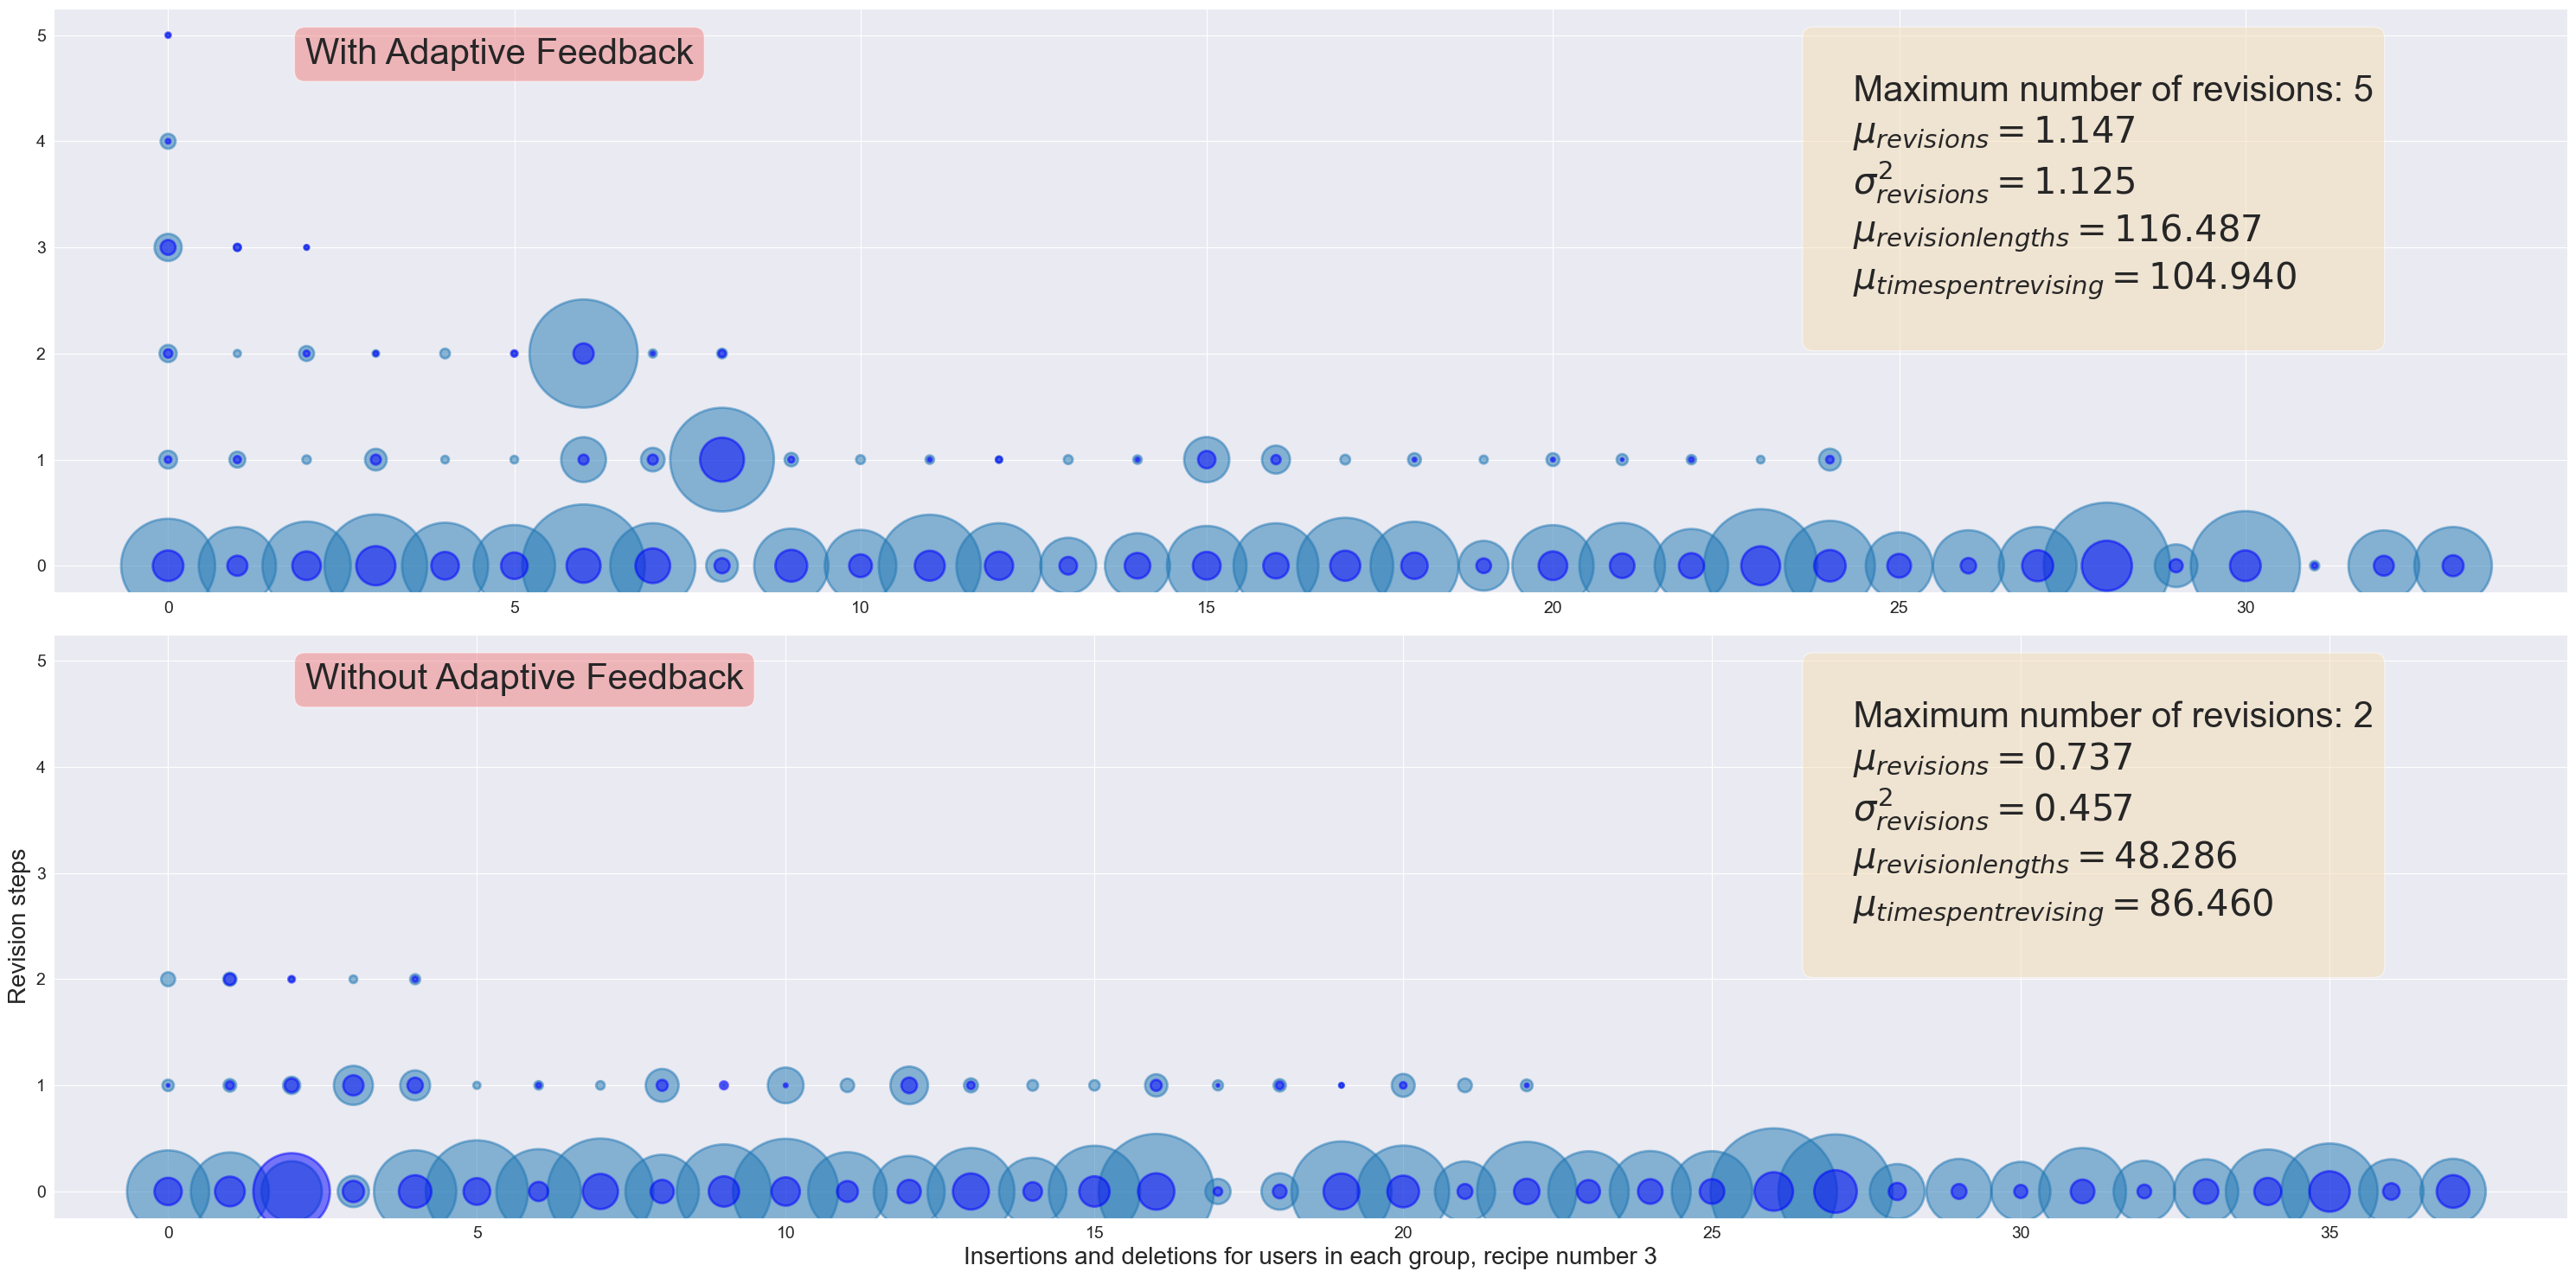

In [35]:
fig, ax = plt.subplots(2,1, figsize=(30,15), sharey=True)
recipe_num =  2
max_revisions, means, variances, avr_rev_lengths, _ = data_computation_on_groups(recipe_num, INDICES)
group_characteristics = ["With Adaptive Feedback", "Without Adaptive Feedback"]
for group in range(1,3):
    text = \
    """
    Maximum number of revisions: {max}
    {mean}
    {var}
    {revision_length_mean}
    {average_time_spent}
    """.format(max=max_revisions[group-1], 
    mean=r'$\mu_{revisions}=%.3f$' % (means[group-1]), 
    var=r'$\sigma^2_{revisions}=%.3f$' % (variances[group-1]),
    revision_length_mean=r'$\mu_{revision lengths}=%.3f$' % (avr_rev_lengths[group-1]),
    average_time_spent=r'$\mu_{time spent revising}=%.3f$' % (get_average_time_spent_per_group(INDICES[group-1], recipe_num=recipe_num))
    )

    data = []
    for i, _ in enumerate(sorted_users):
        if i in INDICES[group-1]:
            try: 
                dfr = get_data_per_session(i)[recipe_num]
                dfr.reset_index(inplace=True)
                data.append(dfr)
            except: 
                    data.append(pd.DataFrame())

    data = sorted(data, key = lambda dfr: len(dfr), reverse=True)    
    list_of_df = [df for df in data]
    dframes = pd.concat(list_of_df)

    y = [[i]*len(list_of_df[i]) for i in range(len(list_of_df))]
    x = [np.arange(len(y_i)) for y_i in y ]
    x = [index for sub in x for index in sub]
    y = [i for sub in y for i in sub]
    z = np.array(dframes['insertions'])
    ins = (dframes['insertions'].values*5).tolist()
    delete = (dframes['deletions'].values*5).tolist()

    ax[group-1].scatter(x=y, y=x, s=ins, alpha=0.5, linewidths=2) 
    ax[group-1].scatter(x=y, y=x, s=delete, alpha=0.5, linewidths=2, c='blue')

# place a text box
#  in upper left in axes coords
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax[group-1].text(0.7, 0.95, text, transform=ax[group-1].transAxes, fontsize=30,
        verticalalignment='top', bbox=props)

    new_props = dict(boxstyle='round', facecolor='lightcoral', alpha=0.5)
    ax[group-1].text(0.1, 0.95, group_characteristics[group-1], transform=ax[group-1].transAxes, fontsize=30,
        verticalalignment='top', bbox=new_props)

plt.xlabel(xlabel='Insertions and deletions for users in each group, recipe number {num}'.format(num=recipe_num+1), fontsize=20)
plt.ylabel(ylabel='Revision steps', fontsize=20)
fig.tight_layout()
plt.savefig('results/bubble plots/recipe {num}.png'.format(num=recipe_num+1))

In [36]:
def compute_diff_percentage(list):
    return round((list[-1] - list[0]) / list[0] * 100, 2)

def compute_text(metric, data):
    text = """  $\Delta$ {metric}
    group 1: {group1}%
    group 2: {group2}%
    """.format(metric=metric, 
    group1=compute_diff_percentage(data.loc['group 1']),
    group2=compute_diff_percentage(data.loc['group 2'])
    )
    return text

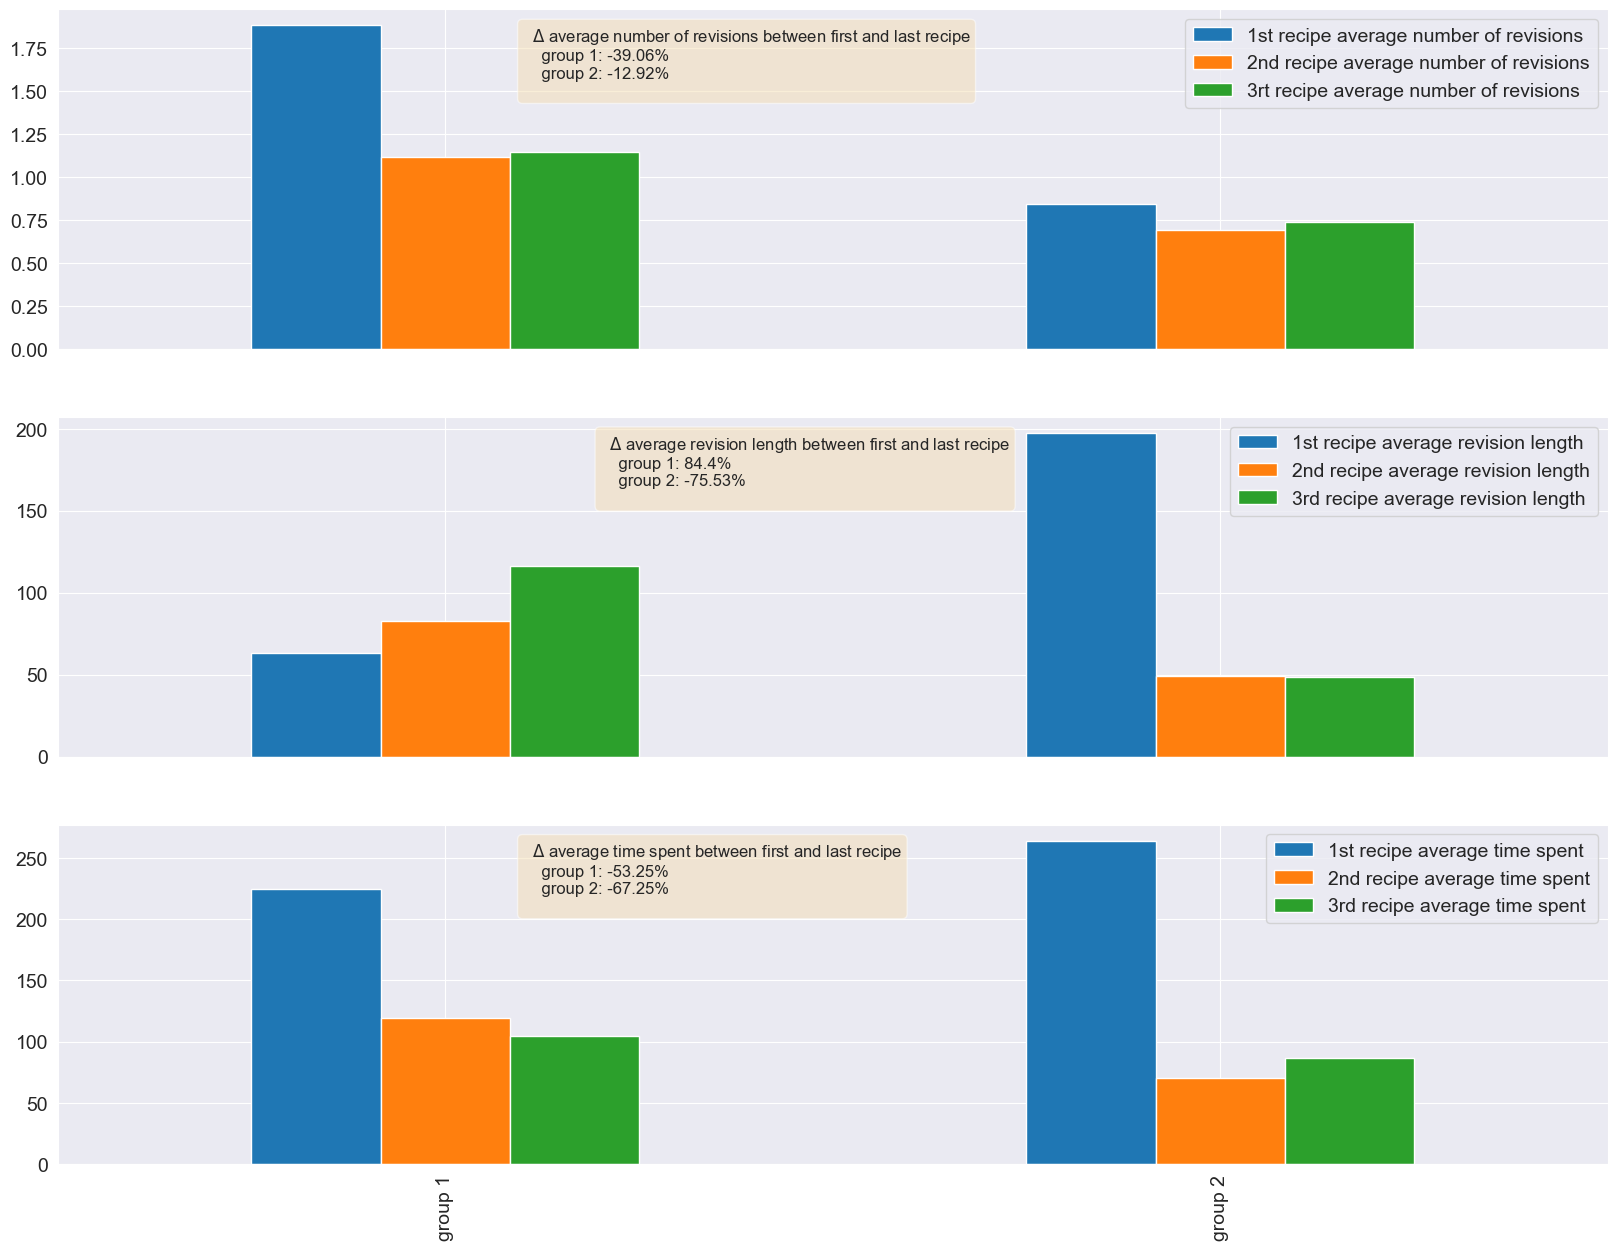

In [37]:
_, means_1, _, avr_rev_lengths_1, _  = data_computation_on_groups(0, INDICES)
_, means_2, _, avr_rev_lengths_2, _ = data_computation_on_groups(1, INDICES)
_, means_3 , _, avr_rev_lengths_3, _ = data_computation_on_groups(2, INDICES)
time_spent = []
for i in range(1,3):
        tup = []
        for j in range(0,3):
                tup.append(get_average_time_spent_per_group(INDICES[i-1], recipe_num=j))
        time_spent.append(tuple(tup))

means = pd.DataFrame((zip(means_1, means_2, means_3)), columns=['1st recipe average number of revisions', '2nd recipe average number of revisions', '3rt recipe average number of revisions'], index=['group 1', 'group 2'])
avr_rev_lengths = pd.DataFrame((zip(avr_rev_lengths_1, avr_rev_lengths_2, avr_rev_lengths_3)), columns=['1st recipe average revision length', '2nd recipe average revision length', '3rd recipe average revision length'], index=['group 1', 'group 2'])
time_spent = pd.DataFrame(time_spent, columns=['1st recipe average time spent', '2nd recipe average time spent', '3rd recipe average time spent'], index=['group 1', 'group 2'])

fig, ax = plt.subplots(3, 1, sharex=True)
means.plot(kind='bar', figsize=(20,15), ax=ax[0])
avr_rev_lengths.plot(kind='bar', figsize=(20,15), ax=ax[1])
time_spent.plot(kind='bar', figsize=(20,15), ax=ax[2])

ax[0].text(0.3, 0.95, compute_text('average number of revisions between first and last recipe', means), transform=ax[0].transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
ax[1].text(0.35, 0.95, compute_text('average revision length between first and last recipe', avr_rev_lengths), transform=ax[1].transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
ax[2].text(0.3, 0.95, compute_text('average time spent between first and last recipe', time_spent), transform=ax[2].transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
plt.savefig('results/summary.png')

In [38]:
#debugging code

def print_user_recipes(index):
    print(sorted_users[index])
    a = np.where(df['user_id'] == sorted_users[index])
    for i in a:
        print(df['recipe'].iloc[i])
    print(map_[index])

index = np.where(np.array(sorted_users) =='62db74da2f7429185dfab004')
#print(index)


print("=====")
#print_user_recipes(index[0][0])
for user in INDICES[1]:
    print_user_recipes(user)

[]
=====
5994b4b88737070001762c8f
7     Ingredients:\r\n700g of pasta\r\n1 L of milk\r...
8     Recipe: macaroni cheese\r\n\r\n\r\nIngredients...
9     Recipe: chicken fajitas\r\n\r\n\r\nIngredients...
10    Recipe: chocolate brownies\r\n\r\n\r\nIngredie...
11    Recipe: chocolate brownies\r\n\r\n\r\nIngredie...
Name: recipe, dtype: object
[7, 9, 10]
5a9bbda1f6dfdd0001ea9639
18    Ingredients:\r\n- 5 white potatoes\r\n- 2 chic...
19    Title: Mediterranean Chicken stew\r\n\r\nIngre...
20    Title: Pesto tenderstem broccoli tagliatelle\r...
21    Title: Lemon cheesecake\r\n\r\nIngredients: \r...
Name: recipe, dtype: object
[18, 20, 21]
5b39fe0206f9f90001fb91c8
28    1. Grate the garlic\r\n2. Flatten the beef min...
29    Ingredients\r\n\r\n\r\n4 garlic gloves\r\n250 ...
30    40g sugar sneap peas\r\n40 g peas\r\n40g beans...
31    Bruschetta\r\n\r\n\r\nIngredients:\r\n40g suga...
32    Korean style fried chicken\r\n\r\n\r\nIngredie...
33    Korean style fried chicken\r\n\r\n\r\nIngredie

Storing variables for other notebooks

In [39]:
%store sorted_users
%store INDICES
%store matching_data

Stored 'sorted_users' (list)
Stored 'INDICES' (list)
Stored 'matching_data' (DataFrame)


Count only the edits so not when the users start their recipes

In [40]:
dframe_with_n_recipes = []
dframe_all_recipes_combined = []
for group in [1,2]:
    for user in INDICES[group-1]:
        time_spent = get_time_spent_for_user(user, recipe_num=0)
        num_revisions = 0
        total_edits = 0
        for i , session in enumerate(get_data_per_session(user)):
            session = session.values
            for revision in session[1:]:
                num_revisions += 1
                edits = revision[0] + revision[1]
                total_edits += edits
                dframe_with_n_recipes.append({'user_id': user, 'revisions': edits, 'group': group, 'recipe number': i+1, 'time spent revising (seconds)': time_spent})
        dframe_all_recipes_combined.append({'user_id': user, 'revisions': total_edits, 'group': group, 'number of revisions': num_revisions, 'time spent revising (seconds)': time_spent})

dframe_with_n_recipes = pd.DataFrame(dframe_with_n_recipes)
dframe_all_recipes_combined = pd.DataFrame(dframe_all_recipes_combined)

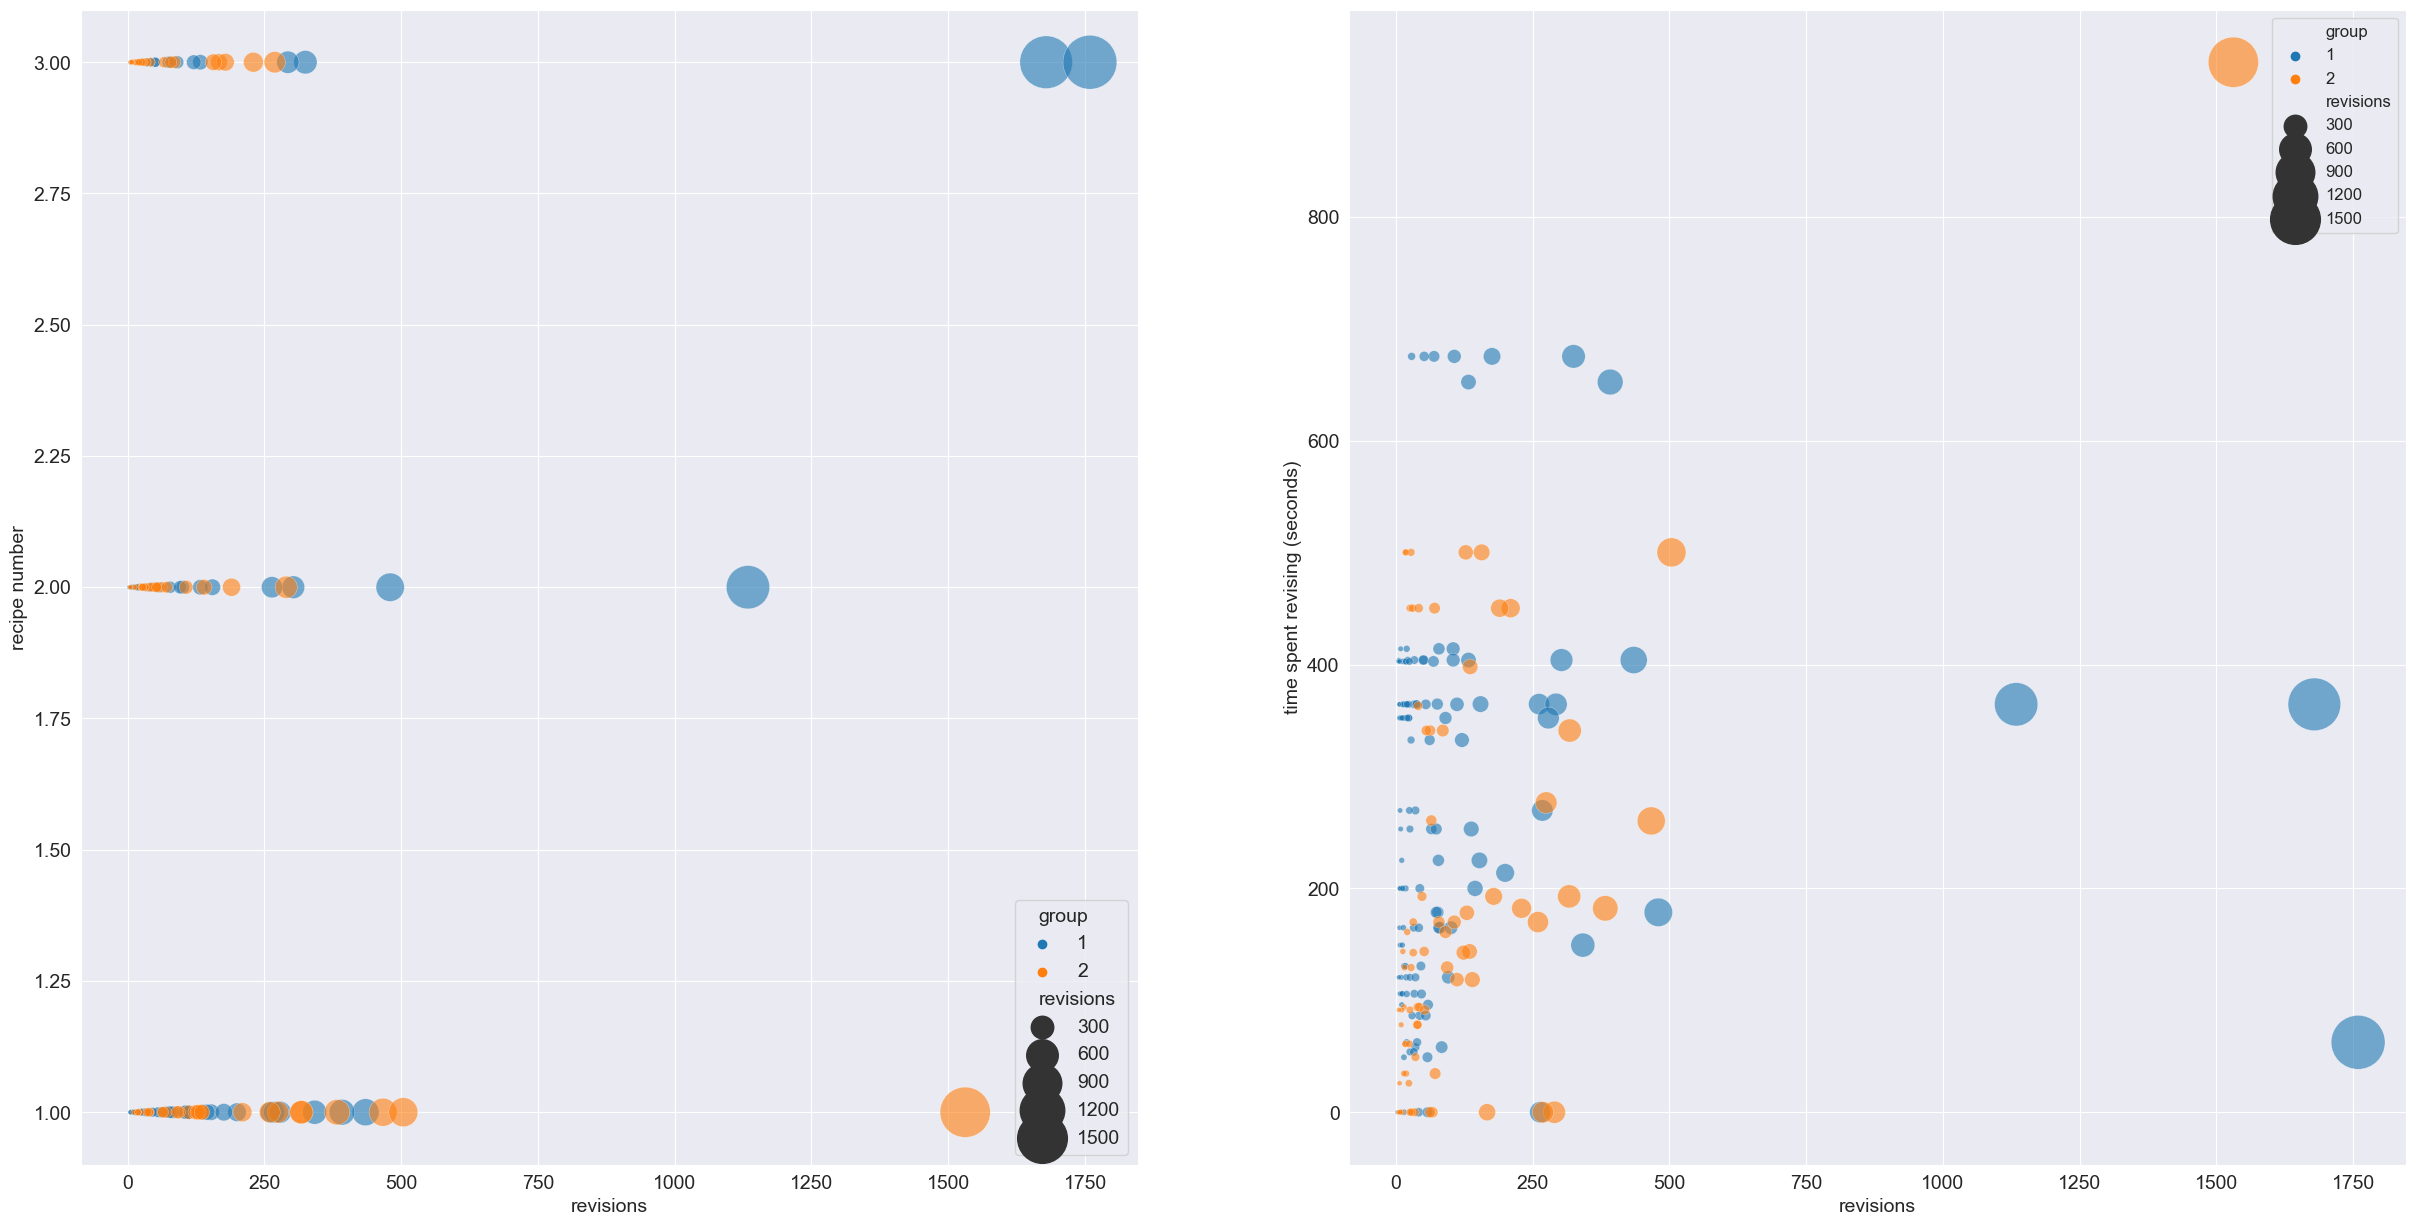

In [41]:
fig,ax = plt.subplots(1,2, figsize=(30,15))
without_outliers = dframe_with_n_recipes[(dframe_with_n_recipes["time spent revising (seconds)"] <= 1000) & (dframe_with_n_recipes["recipe number"] <= 3)]
sns.scatterplot(data=without_outliers, x="revisions", y="recipe number", size="revisions", hue="group", palette='tab10', alpha=0.6, sizes=(10, 1500), ax=ax[0])
sns.scatterplot(data=without_outliers, x="revisions", y="time spent revising (seconds)", size="revisions", hue="group", palette='tab10', alpha=0.6, sizes=(10, 1500), ax=ax[1])
plt.legend(fontsize=12)

#### Interpretation

On average, no group spends much more time on the platform, they balance themselves out. We can argue that users with feedback take time to review all the feedback and the users without well have to come up with revisions by themselves. 
However, in terms of amount of revision, non clear distinction exists between groups. We cant assume users with feedback review much more than users without.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


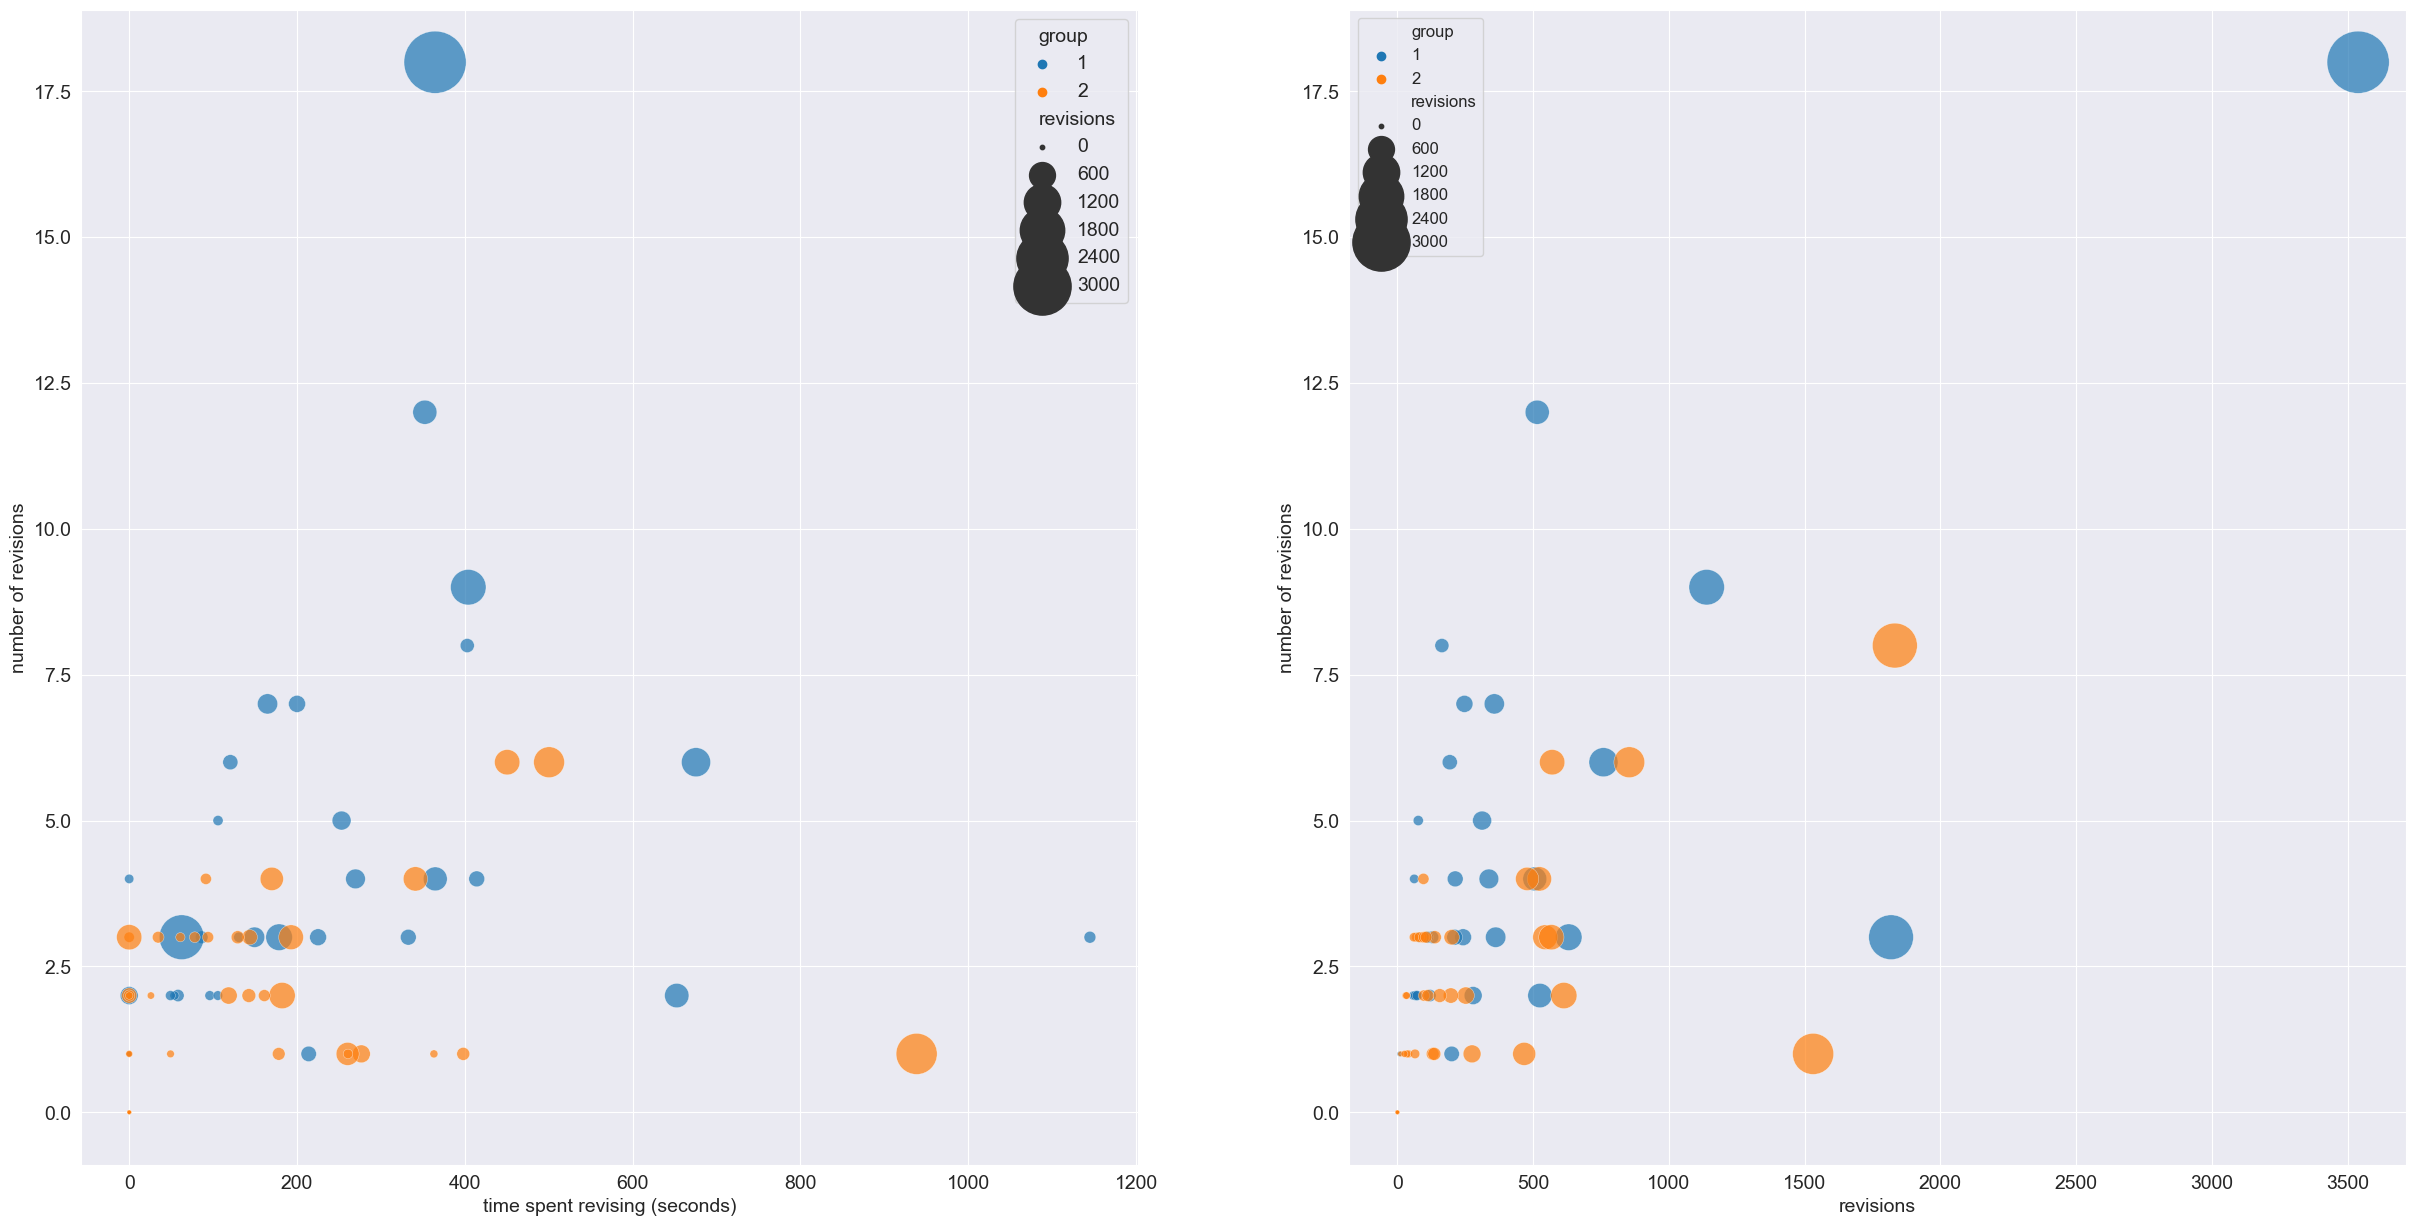

In [42]:
fig,ax = plt.subplots(1,2, figsize=(30,15))
sns.scatterplot(data=dframe_all_recipes_combined[dframe_all_recipes_combined['time spent revising (seconds)'] < 1500], x="time spent revising (seconds)", y="number of revisions", size="revisions", hue="group", palette='tab10', alpha=0.7, sizes=(10, 2000), ax=ax[0])
plt.legend(loc='upper left', fontsize=12)
sns.scatterplot(data=dframe_all_recipes_combined, x="revisions", y="number of revisions", size="revisions", hue="group", palette='tab10', alpha=0.7, sizes=(10, 2000), ax=ax[1])
plt.legend(loc='upper left', fontsize=12)
plt.savefig('results/groupstudy/bubbleplot.png')

#### Interpretations

Clearly, users with feedback dominate in terms of number of revisions. So although they revise more, that doesnt mean that they have more revisions.

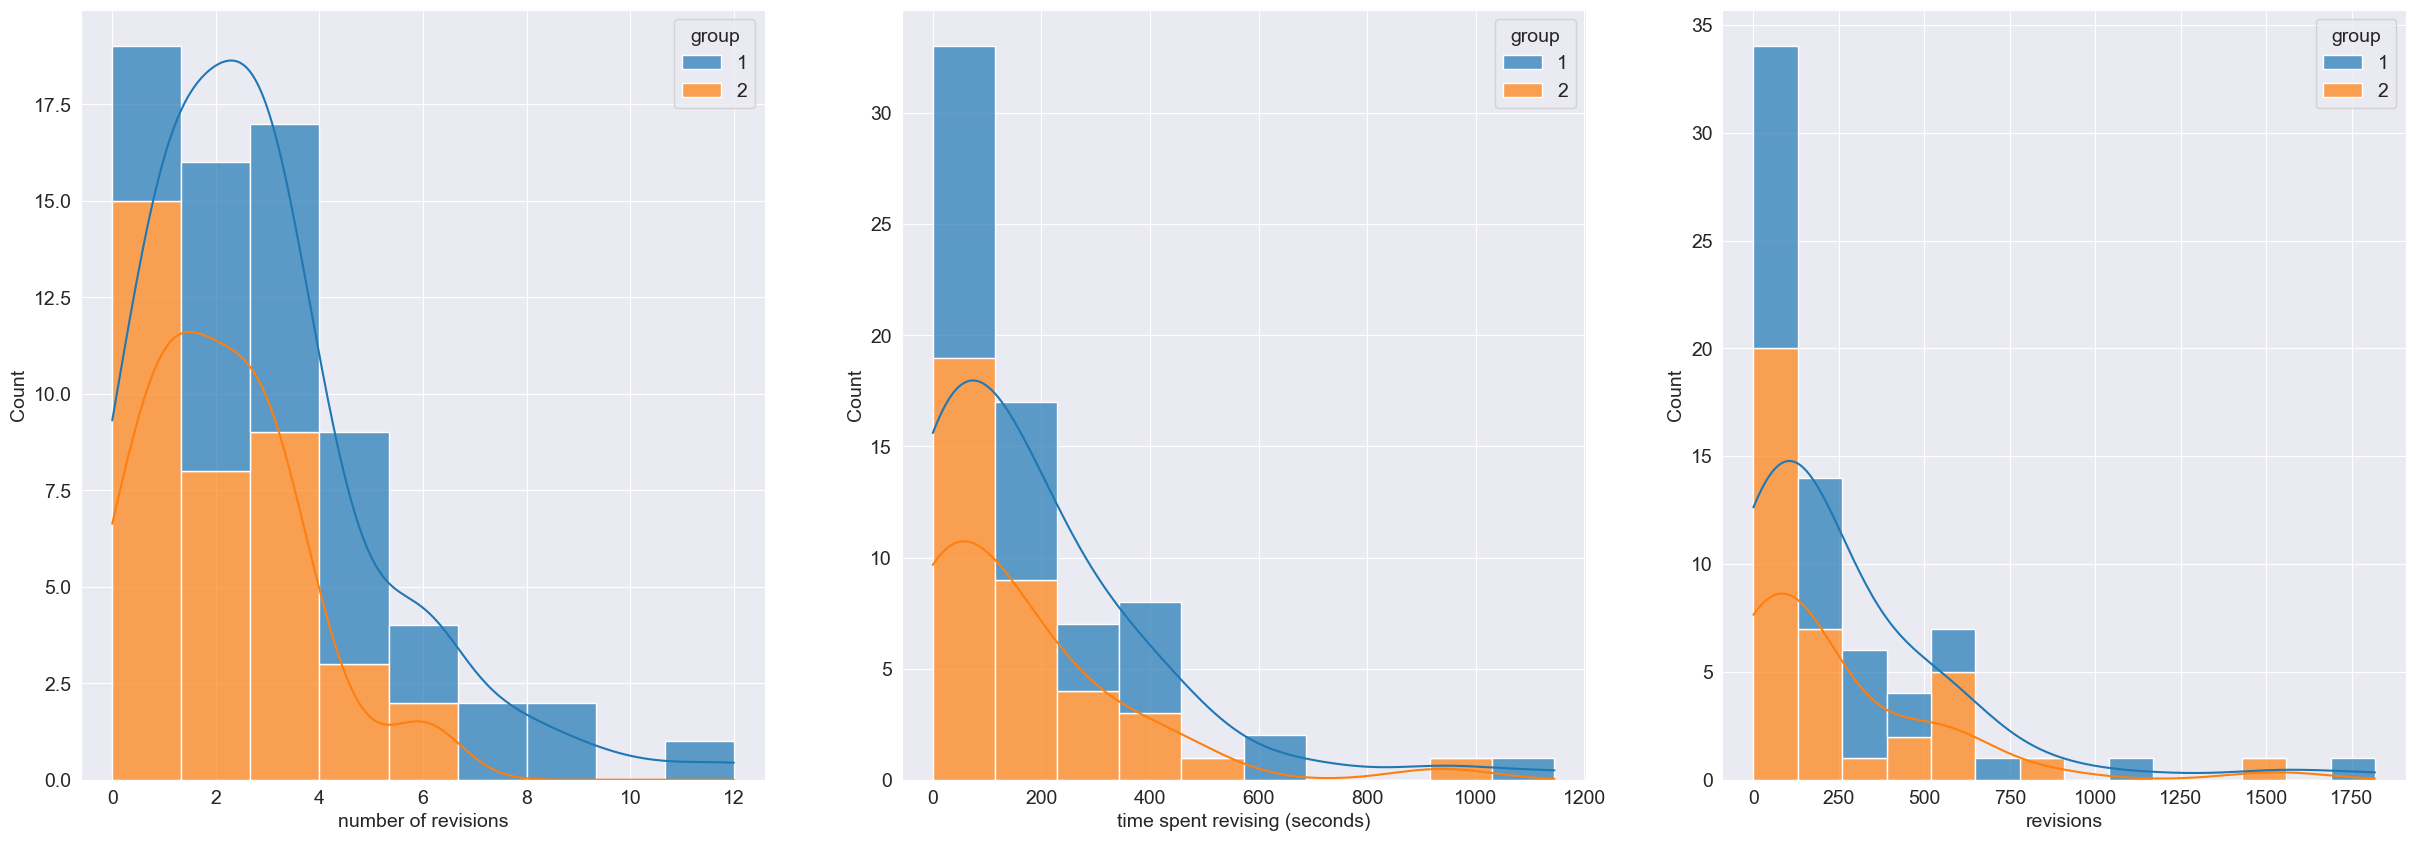

In [43]:
without_outliers = dframe_all_recipes_combined[(dframe_all_recipes_combined["time spent revising (seconds)"] <= 1500) & (dframe_all_recipes_combined["revisions"] <= 3000)]
fig,ax = plt.subplots(1,3, figsize=(30,10))
sns.histplot(data=without_outliers, x="number of revisions", hue="group", palette='tab10', alpha=0.7, multiple='stack', ax=ax[0], kde=True)
sns.histplot(data=without_outliers, x="time spent revising (seconds)", hue="group", palette='tab10', alpha=0.7, multiple='stack', ax=ax[1], kde=True)
sns.histplot(data=without_outliers, x="revisions", hue="group", palette='tab10', alpha=0.7, multiple='stack', ax=ax[2], kde=True)
plt.savefig('results/groupstudy/numrevisions - time spent - total revisions.png')

#### Interpretations

confirms what we saw, number of revisions dominated by users with feedback

Time spent however is pretty balanced between groups. We see in several cases that users without feedback or prompts spend more time than users with feedback.

### How did users rate RELEX?

In [44]:
def get_reviews():
    dfr = []
    for i in [1,2]:
        dfr.append(matching_data[matching_data['group'] == i].filter(['procedural writing rating', 'useful rating', 'more interesting rating', 'hard to understand', 'improved skills']).loc[lambda x: x['procedural writing rating'] >0].mean())
    return dfr

dfr = get_reviews()
dframe = pd.DataFrame({'group1': dfr[0], 'group2': dfr[1]})
dframe.index = ['I can improve my procedural writing skills using Relex ', 'Relex is useful', 'Relex makes writing recipes more interesting', 'Relex is hard to understand', 'I improved my procedural writing skills using Relex']
dframe.head()

,group1,group2
I can improve my procedural writing skills using Relex,5.720930,5.435897
Relex is useful,5.627907,5.358974
Relex makes writing recipes more interesting,5.162791,4.820513
Relex is hard to understand,2.976744,2.461538
I improved my procedural writing skills using Relex,5.139535,4.897436
